In [ ]:
#Instalar la libreria en caso de ser necesario
#!pip install matplotlib

# Librerias 

In [3]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from joblib import dump
from joblib import load
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ( confusion_matrix,classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score,
                             recall_score, f1_score, roc_curve, roc_auc_score
)

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath("docker"))


Importamos los imputadores y codificadores desde la carpeta 'transformadores'


In [5]:
from transformadores.Temporal_GeoTransformer import TemporalGeoTransformer
from transformadores.Hierarchical_Imputer import HierarchicalImputer
from transformadores.Outlier_Capper import OutlierCapper
from transformadores.Cyclic_Encoder_Cleaner import CyclicEncoderCleaner

In [6]:
# Carga datos de dataset en dataframe
df = pd.read_csv('./files/input.csv')

In [7]:
# Cargamos además las coordenadas de Australia
coord_aus = pd.read_csv('https://raw.githubusercontent.com/guillericci/AA1-TUIA-Aranda-Cicoria-Ricci/refs/heads/main/coordenadas_aus.csv')

# Transformacion de datos


In [8]:
#Eliminamos nulos de la variable target
df = df.dropna(subset=['RainTomorrow'])

In [9]:
# Columnas categóricas
cat_cols = df.select_dtypes(include=['object']).columns.difference(['RainTomorrow']).tolist()

In [10]:
# Columnas categóricas para OneHot y Ordinal
onehot_cols = ['Rainfall_cat', 'Evaporation_cat', 'RegionCluster']
binary_cols = ['RainToday']

# Columnas numéricas estandarizables
num_cols = [
    'Sunshine', 'Humidity3pm', 'Cloud9am', 'Cloud3pm', 'anio',
    'Temp9am_cap', 'Temp3pm_cap', 'Pressure9am_cap', 'Pressure3pm_cap',
    'Humidity9am_cap', 'MinTemp_cap', 'MaxTemp_cap',
    'WindGustSpeed_cap', 'WindSpeed9am_cap', 'WindSpeed3pm_cap'
]


Creamos el preprocesador para escalado y codificado de variables.

In [11]:
preprocesador = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), onehot_cols),
    ('binary', OrdinalEncoder(), binary_cols)
])


Creamos el modelo de regresión logística con el parámetro óptimo.

In [12]:
modelo_final = LogisticRegression(
    penalty='l2',
    C=0.07439822123443487,
    solver='liblinear',
    random_state=42
)

Creamos el pipeline.

In [15]:
pipeline_produccion = Pipeline([
    ('geo', TemporalGeoTransformer(coord_df=coord_aus, n_clusters=9)),
    ('imputacion', HierarchicalImputer(
        columnas_num_excluir=['Cloud9am', 'Cloud3pm'],
        columnas_cat=cat_cols + ['Cloud9am', 'Cloud3pm']
    )),
    ('outliers', OutlierCapper()),
    ('cyclic_clean', CyclicEncoderCleaner()),
    ('preprocesamiento', preprocesador),
    ('modelo', modelo_final)
])


Divimos dataset en train y test para poder evaluar el pipeline. 

In [14]:
y = df['RainTomorrow'].map({'No': 0, 'Yes': 1})
X = df.drop(columns=['RainTomorrow'], axis=1)

# División estratificada (porque la clase puede estar desbalanceada)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Entrenamos el Pipeline y lo guardamos


In [16]:
# Entrenar pipeline final con mejores hiperparámetros
pipeline_produccion.fit(X_train, y_train)

#save pipeline
joblib.dump(pipeline_produccion, './docker/pipeline.pkl')


['./docker/pipeline.pkl']

In [17]:
pipeline = joblib.load('./docker/pipeline.pkl')
pipeline

Pipeline(steps=[('geo',
                 TemporalGeoTransformer(coord_df=            Location   Latitude   Longitude
0             Albury -36.074816  146.923828
1      BadgerysCreek -33.884444  150.783056
2              Cobar -31.496667  145.834167
3       CoffsHarbour -30.296263  153.113533
4              Moree -29.462778  149.841667
5          Newcastle -32.926670  151.778900
6          NorahHead -33.281389  151.568611
7      NorfolkIsland -29.032222  167.958611
8            Penrith -33.751389  150.700000
9           R...
                                                   'Humidity9am_cap',
                                                   'MinTemp_cap', 'MaxTemp_cap',
                                                   'WindGustSpeed_cap',
                                                   'WindSpeed9am_cap',
                                                   'WindSpeed3pm_cap']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Rainfall_cat',
                                                   'Evaporation_cat',
                                                   'RegionCluster']),
                                                 ('binary', OrdinalEncoder(),
                                                  ['RainToday'])])),
                ('modelo',
                 LogisticRegression(C=0.07439822123443487, random_state=42,
                                    solver='liblinear'))])

# Docker

Los siguientes comandos para la construccion de la imagen y la ejecucion del container deben ser realizados por consola

Con comando ```cd``` nos situamos sobre la carpeta de docker descargada. Por ejemplo:

```
>>> D:\Downloads\> cd docker
>>> D:\Downloads\docker>

```

Luego construimos la imagen de docker.


```
>>> D:\Downloads\docker> docker build -t inference-python-test .
```

docker build -t inference-python-test .

Para la ejecucion, debemos indicarle el path correspondiente en donde se encuentra. Por ejemplo: 
Si el path es `D:/Downloads`, debo ejecutar: 

`docker run --rm -v "{path}/files:/files" inference-python-test`
```
>>> D:\Downloads\docker> docker run --rm -v "D:/Downloads/files:/files" inference-python-test
```


docker run --rm -v "{path}/files:/files" inference-python-test

## Output

Se creará en la carpeta `files`un archivo `output.csv` con las predicciones

In [19]:
df_output = pd.read_csv('./files/output.csv')
df_output.sample(5)

,RainTomorrow_pred
35373,1
36423,0
5427,1
120230,0
136981,0


# Ejemplo de prediccion

In [20]:
# Tomar una fila de X_test para hacer predicción
indice = 0
nueva_fila = X_test.iloc[[indice]]  # Usamos doble corchete para mantener el formato DataFrame

# Predecir la probabilidad de clase 1 (lluvia)
proba = pipeline.predict_proba(nueva_fila)[:, 1]

# Aplicar umbral custom
umbral = 0.1
prediccion = (proba >= umbral).astype(int)

# Mostrar resultados
print(f"Predicción para fila {indice} del conjunto de prueba : {'Lloverá' if prediccion[0] == 1 else 'No lloverá'}")


Predicción para fila 0 del conjunto de prueba : Lloverá


Evaluamos el rendimiento del modelo para los datos de prueba. Este paso es para verificar que el pipeline este funcionando como esperamos.


 Reporte de clasificación (umbral 0.1):
              precision    recall  f1-score   support

           0       0.96      0.60      0.74     22064
           1       0.40      0.92      0.56      6375

    accuracy                           0.67     28439
   macro avg       0.68      0.76      0.65     28439
weighted avg       0.84      0.67      0.70     28439

 Métrica personalizada (custom): 0.746
 Recall clase 1: 0.919
 Precisión clase 1: 0.400
 Matriz de confusión (umbral ajustado):


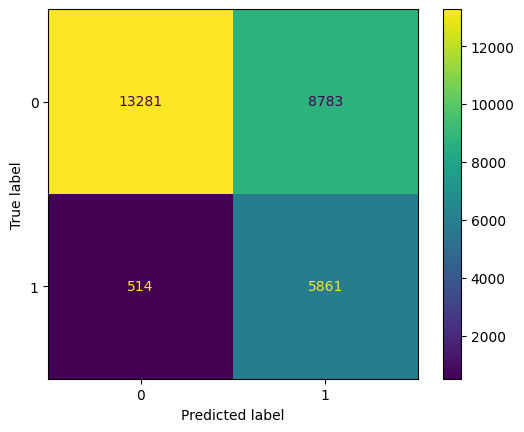

In [21]:
# Predecir clases
y_pred = pipeline.predict(X_test)

# Predecir probabilidades
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Predicción con umbral custom
y_pred_custom = (y_proba >= umbral).astype(int)

# Reporte de clasificación
print(f"\n Reporte de clasificación (umbral {umbral}):")
print(classification_report(y_test, y_pred_custom))

# Métrica personalizada
precision_1 = precision_score(y_test, y_pred_custom, pos_label=1)
recall_1 = recall_score(y_test, y_pred_custom, pos_label=1)
custom_metric = (2 * recall_1 + precision_1) / 3

print(f" Métrica personalizada (custom): {custom_metric:.3f}")
print(f" Recall clase 1: {recall_1:.3f}")
print(f" Precisión clase 1: {precision_1:.3f}")

# Matriz de confusión
print(" Matriz de confusión (umbral ajustado):")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_custom)
plt.show()